# TP4 : Équations différentielles partielles
## PHY-3500: Physique numérique (H2021) - 2 avril 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

### L'équation de Schrödinger et la méthode de Crank-Nicolson

On doit un programme qui effectuera la résolution de l'équation de Schrödinger selon la méthode Crank-Nicolson pour un électron. On doit donc calculer $\psi(t+h)$ à partir de la condition initiale de l'électron et on utilise $h=10^{-18} \mathrm{~s}$ et $N=1000$ avec $ a=L / N $. 

#### Question 1

La première étape consiste à calculer la quantité $\mathbf{v}=\mathbf{B} \psi$. On ne doit pas recourir à une librairie externe mais plutôt exploiter le fait que $\mathrm{B}$ est tridiagonale. En effet, on sait que l'expression simple de $v_{i}$ est possible et est donnée par

$$
v_i = b_1 \psi_i + b_2 (\psi_{i+1} + \psi_{i-1}).
$$

Cette expression à été trouvée dans le livre Computational Physics de Mark Newman.


On définit d'abord les constantes importantes du problème.

In [2]:
hbar = const.hbar
m = const.electron_mass # [kg]
L = 10**-8  # [m]
h = 10**-18 # [s]
N = 1000    # [-]
a = L/N     # [m]

sigma = 1*10**-10   # [m]
k = 5*10**10        # [m^-1]

On doit aussi définir les coefficients des matrices symétriques et tridiagonales A et B de l'équation de Crank-Nicolson.

In [3]:
a1 = 1 + h*1j*hbar / (2*m*a**2)
a2 = -h*(1j*hbar / (4*m*a**2))
b1 = 1 - h*(1j*hbar / (2*m*a**2))
b2 = h*(1j*hbar / (4*m*a**2))

On définit ensuite une fonction qui retourne la fonction d'onde initiale de l'électron à $t=0$ secondes.

In [4]:
def initial_wave_function(x, L, sigma, k):
    x0 = L/2 # [m]
    return np.exp(-((x-x0)**2)/(2*sigma**2))*np.exp(1j*k*x)


On définit les conditions initiales et on obtient la fonction d'onde initial de l'électron sous forme d'un vecteur. On sait que $\psi=0 \text { aux parois à } x=0 \text { et } x=L$.

In [5]:
x = np.linspace(0, L, N+1)
psi_0 = initial_wave_function(x=x, L=L, sigma=sigma, k=k)
psi_0[[0, N]] = 0

On définit une fonction qui permet d'obtenir le vecteur $v$ à partir d'une fonction d'onde $\psi$ et des valeurs sur les diagonales d'une matrice $B$ tridiagonale.

In [6]:
def get_vector_v(psi, b1, b2):
    N = len(psi) - 1
    v = np.zeros(len(psi), complex)

    v[0] = b1*psi[0] + b2*psi[1]
    v[1:N] = b1*psi[1:N] + b2*(psi[2:N+1] + psi[0:N-1])
    v[N] = b1*psi[N] + b2*psi[N-1]

    return v

On peut ensuite trouver le vecteur $v$ dans notre cas.

In [7]:
v = get_vector_v(psi=psi_0, b1=b1, b2=b2)

On trace les vecteurs $\psi$ et $v$ pour les visualiser.

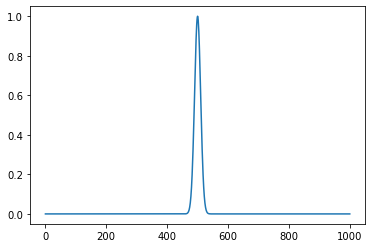

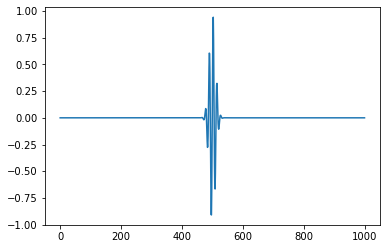

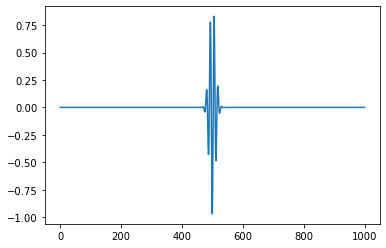

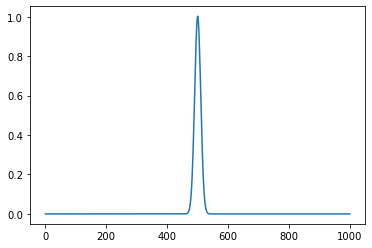

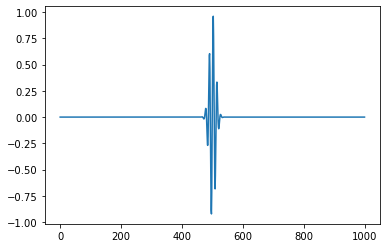

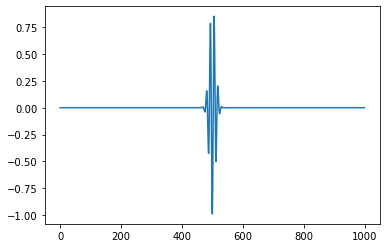

In [8]:
plt.plot(np.abs(psi_0))
plt.show()

plt.plot(np.real(psi_0))
plt.show()

plt.plot(np.imag(psi_0))
plt.show()

plt.plot(np.abs(v))
plt.show()

plt.plot(np.real(v))
plt.show()

plt.plot(np.imag(v))
plt.show()


#### Question 2

On doit résoudre le système $\mathbf{A x}=\mathbf{v}$ en recourant à un algorithme spécifiquement conçu pour les matrices tridiagonales. La fonction suivante est issue de l'algorithme de Thomas conçu pour les matrices tridiagonales (annexe E Newman). La fonction *solve_banded_equation* retourne un single array de même longueur que le vecteur v du système Ax = v. 
A est un array qui contient la matrice et les variables up et down spécifient le nombre d'éléments, au dessus et
sous la diagonale, de la matrice qui ne sont pas des 0. La fonction consiste à utiliser une matrice A avec 
comme éléments de ses rangées les diagonales de la matrice tridiagonales et à effectuer une élimation gausienne.

In [9]:
def solve_banded_equation(A_array, v_array, upper, lower):

    # La taille du système est donnée par la longueur du vecteur v 
    A = np.copy(A_array)
    v = np.copy(v_array)
    N = len(v)

    # Élimination gaussienne
    for i in range(N):

        # Facteur de normalisation
        div = A[upper, i]

        # Mise à jour initial du vecteur v
        v[i] /= div
        for k in range(1, lower+1):
            if i+k < N:
                v[i+k] -= A[upper+k, i]*v[i]

        # Normalisation de la rangée pivot de A et la soustraire des rangées inférieures
        for m in range(upper):
            j = i + upper - m
            if j<N:
                A[m,j] /= div
                for k in range(1, lower+1):
                    A[m+k, j] -= A[upper+k, i]*A[m,j]

    # Substitution arrière
    for m in range(N-2, -1, -1):
        for i in range(upper):
            j = m + upper - i
            if j<N:
                v[m] -= A[i,j]*v[j]

    return v

On définit d'abord la matrice A telle qu'elle est.

In [10]:
A = np.zeros((N+1,N+1), complex)

for i in range(N):
    A[i, i] = a1
    A[i+1, i] = a2 
    A[i, i+1] = a2

A[N, N] = a1


Dans notre cas, la fonction *solve_banded_equation* a plutôt besoin de la matrice $A$ sous une forme différente, soit la matrice A avec ses diagonales originales mises sur des rangées.

In [11]:
A_diag_as_rows = np.empty((3, N+1),complex)

A_diag_as_rows[0,:] = a2
A_diag_as_rows[1,:] = a1
A_diag_as_rows[2:,] = a2


On peut ensuite résoudre le système d'équation $A x = v$ qui est, en d'autres termes, $\mathbf{A} \psi(t+h)=\mathbf{B} \psi(t)$. On obtient donc $\psi(t+h)$ et on visualise cette fonction d'onde sur un graphique.

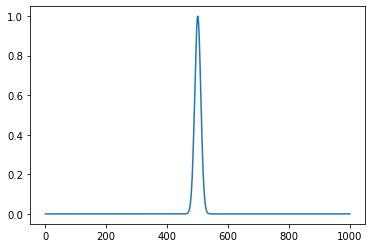

In [12]:
psi_1 = solve_banded_equation(A_diag_as_rows, v, 1, 1)

plt.plot(np.abs(psi_1))
plt.show()


#### Question 3

Créer une animation des fonctions d'onde dans le temps. Utiliser matplotlib.animation est probablement mieux que vpython.

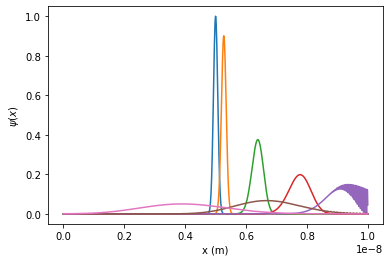

In [13]:
psi = psi_0
# Main loop
# store the wavefunction at each time step in a list
solution = [psi]
for i in range(2000):
    v = get_vector_v(psi, b1=b1, b2=b2)
    
    psi = solve_banded_equation(A_array=A_diag_as_rows, v_array=v, upper=1, lower=1)
    solution.append(psi)

x_points = np.linspace(0, L, N + 1)

plt.plot(x_points, abs(solution[0]) ** 2)
plt.plot(x_points, abs(solution[49]) ** 2)
plt.plot(x_points, abs(solution[250]) ** 2)
plt.plot(x_points, abs(solution[500]) ** 2)
plt.plot(x_points, abs(solution[750]) ** 2)
plt.plot(x_points, abs(solution[1500]) ** 2)
plt.plot(x_points, abs(solution[2000]) ** 2)
plt.xlabel("x (m)")
plt.ylabel("$\psi(x)$")
plt.show()

#### Question 4

#### Question 5

Idée:

- On voit un mouvement vers la droite dû à kappa > 0.
- On voit de la dispersion de la fonction d'onde au fil du temps.
- Mettre kappa = 0 pour voir le cas sans momentum.

CI_BAS SOLUTION DU LIVRE

In [14]:
from __future__ import division, print_function
from os import sys
sys.path.append('cpresources')
from scipy.linalg import solve_banded
from pylab import *

h = 1e-18*10
hbar = 1.0546e-36
L = 1e-8
M = 9.109e-31
N = 1000 # Grid slices

a = L/N

a1 = 1 + h*hbar/2/M/a**2*1j
a2 = -h*hbar*1j/4/M/a**2
b1 =  1 - h*hbar/2/M/a**2*1j
b2 =  h*hbar*1j/4/M/a**2

ksi = zeros(N+1,complex)

def ksi0(x):
	x0 = L/2
	sigma = 1e-10
	k = 5e10
	return exp(-(x-x0)**2/2/sigma**2)*exp(1j*k*x)

x = linspace(0,L,N+1)
ksi[:] = ksi0(x)
ksi[[0,N]]=0

A = empty((3,N),complex)

A[0,:] = a2
A[1,:] = a1
A[2:,] = a2

#==============================================================================
for i in range(100):
# v = b1*ksi[1:N] + b2*(ksi[2:N+1] + ksi[0:N-1])
# 	ksi[1:N] = banded(A,v,1,1)
#==============================================================================

#plot(ksi)

#==============================================================================
# Ap = zeros((N-1,N-1),complex)
# for i in range(N-2):
# 	Ap[i,i] = a2
# 	Ap[i+1,i] = a1 #Bottom
# 	Ap[i,i+1] = a1 #Right
# Ap[N-2,N-2] = a2
#==============================================================================

	from vpython import *

ksi_c = curve()
ksi_c.set_x(x-L/2)

#ksi = banded(A,v,1,1)
while True:
	rate(30)
	ksi_c.set_y(real(ksi)*1e-9)
	ksi_c.set_z(imag(ksi)*1e-9)	
	for i in range(20):
		v = b1*ksi[1:N] + b2*(ksi[2:N+1] + ksi[0:N-1])
		ksi[1:N] = banded(A,v,1,1)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AttributeError: 'curve' object has no attribute 'set_x'

In [ ]:
from scipy.linalg import solve_banded
from numpy import matmul, exp, linspace, array, zeros, empty
from pylab import plot, show, ylabel, xlabel

# Constants
m = 9.109 * 10 ** -31  # electron mass
L = 10 ** -8  # m
x0 = L / 2
sigma = 10 ** -10  # m
k = 5 * 10 ** 10  # 1/m
h_bar = 1.05 * 10 ** -34
N = 1000  # number of spatial slices
a = L / N  # spatial distance between points
h = 10 ** -18  # time step in seconds
a1 = 1 + 1j * h * h_bar / (2 * m * a ** 2)
a2 = - h * h_bar * 1j / (4 * m * a ** 2)
b1 = 1 - 1j * h * h_bar / (2 * m * a ** 2)
b2 = - a2


def psi_0(x):
    return exp(-(x - x0) ** 2 / (2 * sigma ** 2)) * exp(1j * k * x)


# initial conditions
x_points = linspace(0, L, N + 1)
psi = array(list(map(psi_0, x_points)), complex)
psi[0] = psi[N - 1] = 0

# Create the matrix A
# A = zeros([N + 1, N + 1], complex)
# A[0, 0] = a1
# A[0, 1] = a2
# A[N, N - 1] = a2
# A[N, N] = a1
# for i in range(N):
#     A[i, i - 1] = a2
#     A[i, i] = a1
#     A[i, i + 1] = a2
#
# # Create the matrix B
# B = zeros([N + 1, N + 1], complex)
# B[0, 0] = b1
# B[0, 1] = b2
# B[N, N - 1] = b2
# B[N, N] = b1
# for i in range(N):
#     B[i, i - 1] = b2
#     B[i, i] = b1
#     B[i, i + 1] = b2

# Create the matrix A in the form appropriate for the function solve_banded
A2 = empty([3, N + 1], complex)
A2[0, 0] = 0
A2[0, 1:] = a2
A2[1, :] = a1
A2[2, 0: N] = a2
A2[2, N] = 0

print(A2)

# Main loop
# store the wavefunction at each time step in a list
solution = [psi]
for i in range(300):
    psi[1: N] = b1 * psi[1: N] + b2 * (psi[2:] + psi[0: N - 1])
    psi = solve_banded((1, 1), A2, psi)
    solution.append(psi)

plot(x_points, abs(solution[0]) ** 2)
plot(x_points, abs(solution[49]) ** 2)
plot(x_points, abs(solution[250]) ** 2)
xlabel("x (m)")
ylabel("$\psi(x)$")
show()
